In [1]:
%load_ext autoreload
%autoreload 2

from functools import lru_cache
import sys
sys.path.append("../")
from os.path import join
from IPython.display import display
from functools import partial

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rc('text', usetex=True)

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = r"""
\usepackage{sansmath}
\sansmath
""" #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = 'Helvetica, Avant Garde, Computer Modern Sans serif' # Choose a nice font here

from scipy.stats import ttest_ind, sem
from scipy.fft import fft2
import scipy
import joblib
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from skimage.segmentation import mark_boundaries
from scipy.stats import pearsonr
import seaborn as sns
import pandas as pd
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_rows', 128)


from spurious_ml.datasets import add_spurious_correlation, add_colored_spurious_correlation
from spurious_ml.models.torch_utils import archs
from spurious_ml.variables import auto_var
from params import *
from utils import params_to_dataframe

fontsize=16

In [2]:
def mlp_pred_fn(X, model, device="cuda"):
    dset = torch.utils.data.TensorDataset(torch.from_numpy(X.reshape(len(X), -1)).float())
    loader = torch.utils.data.DataLoader(dset, batch_size=256)
    
    model.to(device).eval()
    fetX = []
    for (x, ) in tqdm(loader, desc="[pred_fn]"):
        fetX.append(model(x.to(device)).cpu().detach().numpy())
    fetX = np.concatenate(fetX, axis=0)
    return fetX

def cnn_pred_fn(X, model, device="cuda"):
    if len(X.shape) == 4:
        X = X.transpose(0, 3, 1, 2)
        
    dset = torch.utils.data.TensorDataset(torch.from_numpy(X).float())
    loader = torch.utils.data.DataLoader(dset, batch_size=128)
    
    model.to(device).eval()
    fetX = []
    #for (x, ) in loader:
    for (x, ) in tqdm(loader, desc="[pred_fn]"):
        fetX.append(model(x.to(device)).cpu().detach().numpy())
        #fetX.append(model.feature_extractor(x.to(device)).cpu().detach().flatten(1).numpy())
    fetX = np.concatenate(fetX, axis=0)
    return fetX

class CLF():
    def __init__(self, model):
        self.model = model
        
    def predict(self, X, device="cuda"):
        return pred_fn(X, self.model, device=device)

In [3]:
@lru_cache(maxsize=None)
def evaluate(ds_name, model_path, arch, spurious_version, seed):
    trnX, trny, tstX, tsty, spurious_ind = auto_var.get_var_with_argument("dataset", ds_name)
    n_classes = len(np.unique(trny))
    n_channels = trnX.shape[-1]
    res = torch.load(model_path)
    model = getattr(archs, arch)(n_features=(np.prod(trnX.shape[1:]), ), n_channels=n_channels, n_classes=n_classes)
    model.load_state_dict(res['model_state_dict'])
    
    if 'MLP' in arch:
        pred_fn = mlp_pred_fn
    else:
        pred_fn = cnn_pred_fn
    
    tst_preds = pred_fn(tstX, model)
    tst_preds = scipy.special.softmax(tst_preds, axis=1)
    modified_tstX = np.copy(tstX)
    if n_channels == 3:
        modified_tstX = add_colored_spurious_correlation(modified_tstX, spurious_version, seed)
    else:
        modified_tstX = add_spurious_correlation(modified_tstX, spurious_version, seed)
    mod_tst_preds = pred_fn(modified_tstX, model)
    mod_tst_preds = scipy.special.softmax(mod_tst_preds, axis=1)
    return mod_tst_preds, tst_preds, tsty

In [4]:
def get_model_path(base_dset, spurious_version, i, tar_cls, seed, arch, momentum, optimizer, lr, model_seed,
                   bs=None, wd=0.0, gi=None, depth=None, noise_level=None, noise_multiplier=None, grad_clip=None, folder="train_classifier"):
    ds_name = f"{base_dset}{spurious_version}-{i}-{tar_cls}-{seed}"
    if folder == "train_classifier":
        if base_dset in ['mnist', 'fashion']:
            bs = 128 if bs is None else bs
            if grad_clip is not None:
                 model_path = f"../models/{folder}/{bs}-{ds_name}-70-{grad_clip}-{lr}-ce-tor-{arch}-{momentum}-{optimizer}-{model_seed}-{wd}.pt"
            elif noise_multiplier is not None:
                 model_path = f"../models/{folder}/{bs}-{ds_name}-70-{lr}-ce-tor-{arch}-{momentum}-{noise_multiplier}-noisy{optimizer}-{model_seed}-{wd}.pt"
            else:
                 model_path = f"../models/{folder}/{bs}-{ds_name}-70-{lr}-ce-tor-{arch}-{momentum}-{optimizer}-{model_seed}-{wd}.pt"
        else:
            bs = 64 if bs is None else bs
            if grad_clip is not None:
                model_path = f"../models/{folder}/128-{ds_name}-70-{grad_clip}-{lr}-aug01-ce-tor-{arch}-{momentum}-{optimizer}-{model_seed}-{wd}.pt"
            elif noise_multiplier is not None:
                model_path = f"../models/{folder}/128-{ds_name}-70-{lr}-aug01-ce-tor-{arch}-{momentum}-{noise_multiplier}-noisy{optimizer}-{model_seed}-{wd}.pt"
            else:
                model_path = f"../models/{folder}/128-{ds_name}-70-{lr}-aug01-ce-tor-{arch}-{momentum}-{optimizer}-{model_seed}-{wd}.pt"
    elif folder == "incremental_retraining":
        if "cifar10" == base_dset:
            model_path = f"../models/{folder}/128-{ds_name}-140-{lr}-aug01-ce-tor-{arch}-128-{ds_name}-70-{lr}-aug01-ce-tor-{arch}-{momentum}-{optimizer}-0-{wd}.pt-{momentum}-{optimizer}-0-{wd}.pt"
        else:
            model_path = f"../models/{folder}/128-{ds_name}-140-{lr}-ce-tor-{arch}-128-{ds_name}-70-{lr}-ce-tor-{arch}-{momentum}-{optimizer}-0-0.0.pt-{momentum}-{optimizer}-0-0.0.pt"
    elif folder == "forget_retrain":
        if "cifar10" == base_dset:
            if 'adam' in optimizer:
                old_lr = 0.01
            else:
                old_lr = 0.1
            model_path = f"../models/{folder}/128-{ds_name}-140-all_normal-{lr}-aug01-ce-tor-{arch}-128-{ds_name}-70-{old_lr}-aug01-ce-tor-{arch}-{momentum}-{optimizer}-0-{wd}.pt-{momentum}-{noise_level}-{optimizer}-0-{wd}.pt"
        else:
            model_path = f"../models/{folder}/128-{ds_name}-140-all_normal-{lr}-ce-tor-{arch}-128-{ds_name}-70-0.01-ce-tor-{arch}-{momentum}-{optimizer}-0-0.0.pt-{momentum}-{noise_level}-{optimizer}-0-0.0.pt"
    elif folder == "group_influence":
        if "cifar10" == base_dset:
            if gi is not None and depth is None:
                model_path = f"../models/{folder}/128-{ds_name}-{gi}-aug01-ce-tor-altResNet20Norm02-128-{ds_name}-70-{lr}-aug01-ce-tor-altResNet20Norm02-{momentum}-{optimizer}-0-0.0001.pt-sgd-0.pt"
            elif gi is not None and depth is not None:
                model_path = f"../models/{folder}/128-{ds_name}-{depth}-{gi}-aug01-ce-tor-altResNet20Norm02-128-{ds_name}-70-{lr}-aug01-ce-tor-altResNet20Norm02-{momentum}-{optimizer}-0-0.0001.pt-sgd-0.pt"
            else:
                model_path = f"../models/{folder}/128-{ds_name}-aug01-ce-tor-altResNet20Norm02-128-{ds_name}-70-{lr}-aug01-ce-tor-altResNet20Norm02-{momentum}-{optimizer}-0-0.0001.pt-sgd-0.pt"
        else:
            if gi is not None and depth is None:
                model_path = f"../models/{folder}/128-{ds_name}-{gi}-ce-tor-{arch}-128-{ds_name}-70-{lr}-ce-tor-{arch}-{momentum}-{optimizer}-0-0.0.pt-sgd-0.pt"
            elif gi is not None and depth is not None:
                model_path = f"../models/{folder}/128-{ds_name}-{depth}-{gi}-ce-tor-{arch}-128-{ds_name}-70-{lr}-ce-tor-{arch}-{momentum}-{optimizer}-0-0.0.pt-sgd-0.pt"
            else:
                model_path = f"../models/{folder}/128-{ds_name}-ce-tor-{arch}-128-{ds_name}-70-{lr}-ce-tor-{arch}-{momentum}-{optimizer}-0-0.0.pt-sgd-0.pt"
    return ds_name, model_path

# MNIST/Fashion

In [12]:
base_dset = "mnist"
#base_dset = "fashion"

threshold = 1e-1

n_samples = [1, 3, 5, 10, 20, 100]
optimizers = ['adam',]
#optimizers = ['sgd']
spurious_versions = ['v20']
spurious_versions = ['v8']
architecures = ['LargeMLP']
grad_clips = [None]
tar_clses = [0]
wd = 0.0

opt_methods = {
    'sgd': {
        'methods': ['train_classifier', #'incremental_retraining',
                    'wd-0.0001', 'wd-0.001'],
        'method_names':  ['original', #'retrain',
                          'wd(1e-4)', 'wd(1e-3)'],
    },
    'adam': {
        'methods': ['train_classifier', #'incremental_retraining',
                    'gc-0.00001', 'gc-0.0001', 'gc-0.001', 'gc-0.01', 'gc-0.1',
                    'wd-0.00001', 'wd-0.0001', 'wd-0.001', 'wd-0.05', 'wd-0.01', 'wd-0.1',
                    "ninput00", "ninput01", "ninput02", "ninput03", "ninput04", "ninput05", "ninput06", "ninput07"],
        'method_names':  ['original', #'retrain',
                          'gc(1e-5)', 'gc(1e-4)', 'gc(1e-3)', 'gc(1e-2)', 'gc(1e-1)', 
                          'wd(1e-5)', 'wd(1e-4)', 'wd(1e-3)', 'wd(1e-2)', 'wd(5e-2)', 'wd(1e-1)',
                          "ninput00", "ninput01", "ninput02", "ninput03", "ninput04", "ninput05", "ninput06", "ninput07"],
    },
}

base_dset = "cifar10"
optimizers = ['adam']
spurious_versions = ['v20']
spurious_versions = ['v8']
architecures = ['altResNet20Norm02']
n_samples = [1, 3, 5, 10, 20, 100, 1000]
wd = 0.0

opt_methods = {
    'sgd': {
        'methods': ['train_classifier', #'incremental_retraining',
                    'wd-0.0001', 'wd-0.001'],
        'method_names':  ['original', #'retrain',
                          'wd(1e-4)', 'wd(1e-3)'],
    },
    'adam': {
        'methods': ['train_classifier', #'incremental_retraining',
                    'gc-0.01', 'gc-0.1', 'gc-1.0', 'gc-10.0',
                    'wd-0.000001', 'wd-0.00001', 'wd-0.0001', 'wd-0.001', 'wd-0.01',
                    "ninput00", "ninput01", "ninput02", "ninput03", "ninput04", "ninput05"],
        'method_names':  ['original', #'retrain',
                          'gc(1e-2)', 'gc(1e-1)', 'gc(1e-0)', 'gc(1e-1)', 
                          'wd(1e-6)', 'wd(1e-5)', 'wd(1e-4)', 'wd(1e-3)', 'wd(1e-2)',
                          "ninput00", "ninput01", "ninput02", "ninput03", "ninput04", "ninput05"],
    },
}



all_accs = []
all_results = {}

#methods = ['train_classifier', 'incremental_retraining', 'noisy-0.02', 'noisy-0.01', 'forget_retrain-1.0', 'forget_retrain-0.5', 'wd-0.0001']
#methods = ['train_classifier', 'incremental_retraining', 'noisy-0.02', 'noisy-0.01', 'forget_retrain-0.2', 'forget_retrain-0.1', 'wd-0.0001']

model_seed = 0

for toptimizer in optimizers:
    methods = opt_methods[toptimizer]['methods']
    for tar_cls in tar_clses:
        for spurious_version in spurious_versions:
            for arch in architecures:
                lr = 0.1 if "cifar" in base_dset and toptimizer == "sgd" else 0.01
                optimizer = toptimizer if 'Vgg' not in arch else "sgd"
                momentum = 0. if optimizer == 'adam' else 0.9

                grad_clip = None
                if 'cifar' in base_dset:
                    if grad_clip is None:
                        model_path = f"../models/train_classifier/128-{base_dset}-70-{lr}-aug01-ce-tor-{arch}-{momentum}-{optimizer}-0-0.0.pt"
                    else:
                        model_path = f"../models/train_classifier/128-{base_dset}-70-{grad_clip}-{lr}-aug01-ce-tor-{arch}-{momentum}-{optimizer}-0-0.0.pt"
                else:
                    if grad_clip is None:
                        model_path = f"../models/train_classifier/128-{base_dset}-70-0.01-ce-tor-{arch}-{momentum}-{optimizer}-0-0.0.pt"
                    else:
                        model_path = f"../models/train_classifier/128-{base_dset}-70-{grad_clip}-0.01-ce-tor-{arch}-{momentum}-{optimizer}-0-0.0.pt"
                mod_tst_preds, tst_preds, tsty = evaluate(base_dset, model_path, arch, spurious_version, 0)
                ind = np.arange(len(tsty))
                mod_tst_preds, tst_preds, tsty = mod_tst_preds[ind], tst_preds[ind], tsty[ind]
                baseline_rv = (mod_tst_preds[:, tar_cls] - tst_preds[:, tar_cls]) > threshold
                baseline_nos = baseline_rv.mean()
                baseline_sem = sem(baseline_rv)
                baseline_acc = (tst_preds.argmax(1) == tsty).mean()
                baseline_spacc = (tst_preds.argmax(1) == tsty)[tsty != tar_cls].mean()
                baseline_mod_tst_preds = mod_tst_preds

                key = (optimizer, tar_cls, spurious_version, arch, grad_clip)
                all_results[key] = {}
                for method in methods:
                    mkey = method
                    noise_multiplier = None
                    twd = wd
                    noise_level = None
                    grad_clip = None
                    if 'forget' in method:
                        if 'cifar' in base_dset:
                            lr = 0.001
                        else:
                            lr = 0.0001
                        folder, noise_level = method.split('-')[0], float(method.split('-')[1])
                    elif 'gc' in method:
                        lr = 0.01
                        folder, grad_clip = 'train_classifier', float(method.split('-')[1])
                    elif 'wd' in method:
                        lr = 0.01
                        folder, twd = 'train_classifier', float(method.split('-')[1])
                    elif 'noisy' in method:
                        lr = 0.01
                        folder, noise_multiplier = 'train_classifier', float(method.split('-')[1])
                    elif 'oneothers' in method or 'ninput' in method:
                        lr = 0.01
                        folder, twd = 'train_classifier', 0.
                    else:
                        lr = 0.01
                        folder, twd = 'train_classifier', 0.

                    all_results[key][mkey] = {}
                    all_results[key][mkey]['score_mean'] = [baseline_nos]
                    all_results[key][mkey]['score_sem'] = [0]
                    all_results[key][mkey]['acc'] = [baseline_acc]
                    all_results[key][mkey]['spacc'] = [baseline_spacc]
                    all_results[key]['n_samples'] = n_samples

                    for i in n_samples:
                        taccs, sptaccs, tret, ttest_res = [], [], [], []

                        for seed in range(5):
                            ds_name, model_path = get_model_path(base_dset, spurious_version, i, tar_cls, seed, arch, momentum, optimizer, lr, model_seed,
                                                                 bs=None, wd=twd, gi=None, depth=None, noise_level=noise_level,
                                                                 noise_multiplier=noise_multiplier, grad_clip=grad_clip, folder=folder)
                            if 'oneothers' in method:
                                model_path = model_path.replace(f"128-{ds_name}", "128-oneothers" + ds_name)
                                ds_name = "oneothers" + ds_name
                            elif 'ninput' in method:
                                pre = "aug01-" if 'cifar10' in base_dset else ""
                                pre2 = "-aug01" if 'cifar10' in base_dset else "-"
                                if '01' in method:
                                    model_path = model_path.replace(f"{lr}-{pre}ce", f"{lr}{pre2}noise01-ce")
                                elif '02' in method:
                                    model_path = model_path.replace(f"{lr}-{pre}ce", f"{lr}{pre2}noise02-ce")
                                elif '03' in method:
                                    model_path = model_path.replace(f"{lr}-{pre}ce", f"{lr}{pre2}noise03-ce")
                                elif '04' in method:
                                    model_path = model_path.replace(f"{lr}-{pre}ce", f"{lr}{pre2}noise04-ce")
                                elif '05' in method:
                                    model_path = model_path.replace(f"{lr}-{pre}ce", f"{lr}{pre2}noise05-ce")
                                elif '06' in method:
                                    model_path = model_path.replace(f"{lr}-{pre}ce", f"{lr}{pre2}noise06-ce")
                                elif '07' in method:
                                    model_path = model_path.replace(f"{lr}-{pre}ce", f"{lr}{pre2}noise07-ce")
                            try:
                                mod_tst_preds, tst_preds, tsty = evaluate(ds_name, model_path, arch, spurious_version, seed)
                                ind = np.arange(len(tsty))
                                mod_tst_preds, tst_preds, tsty = mod_tst_preds[ind], tst_preds[ind], tsty[ind]
                                rv = (mod_tst_preds[:, tar_cls] - tst_preds[:, tar_cls]) > threshold
                                taccs.append((tst_preds.argmax(1) == tsty).mean())
                                sptaccs.append((mod_tst_preds.argmax(1) == tsty)[tsty != tar_cls].mean())
                                #taccs.append(mod_tst_preds[rv][:, tar_cls].mean())
                                tret.append(rv.mean())
                            except FileNotFoundError:
                                print(f"missing {model_path}")
                            except:
                                print(f"wierd {model_path}")

                        if taccs:
                            all_results[key][mkey]['score_mean'].append(np.mean(tret))
                            all_results[key][mkey]['score_sem'].append(sem(tret))
                            all_results[key][mkey]['acc'].append(np.mean(taccs))
                            all_results[key][mkey]['spacc'].append(np.mean(sptaccs))
                            all_accs += taccs
                        else:
                            all_results[key][mkey]['score_mean'].append(-1)
                            all_results[key][mkey]['score_sem'].append(-1)
                            all_results[key][mkey]['acc'].append(-1)
                            all_results[key][mkey]['spacc'].append(-1)

print(min(all_accs), max(all_accs), np.mean(all_accs), np.std(all_accs))

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/79 [00:00<?, ?it/s]

0.2871 0.9132 0.7780992857142857 0.18524173039048525


[0.021262499999999997, 0.021824999999999997, 0.0269075, 0.022239999999999996, 0.0106625, 0.0018] [0.90448, 0.9053100000000001, 0.9079900000000001, 0.8884125, 0.8248575, 0.6478124999999999]
[0.021262499999999997, 0.040010000000000004, 0.041225, 0.05272500000000001, 0.02066, 0.0017699999999999999] [0.90448, 0.8357224999999999, 0.7625850000000001, 0.6324274999999999, 0.49761500000000003, 0.3777775]
[0.021262499999999997, 0.02307, 0.0203475, 0.022907499999999997, 0.022635] [0.90448, 0.904135, 0.9048375, 0.90423, 0.9043175000000001]


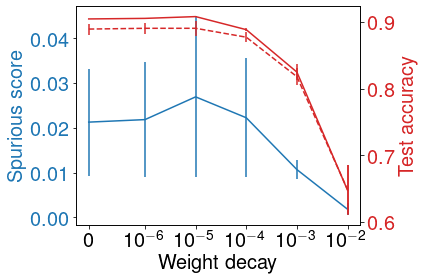

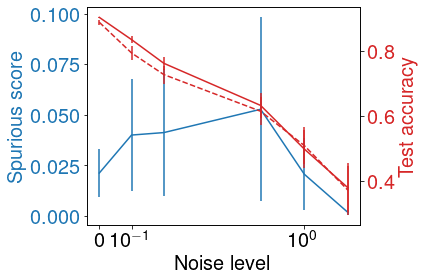

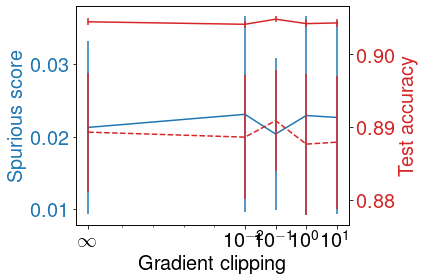

In [17]:
#res = all_results[('adam', 0, 'v20', 'LargeMLP', None)]
arch = architecures[0]
spurious_version = spurious_versions[0]
res = all_results[('adam', 0, spurious_version, arch, None)]

#res = all_results[('adam', 0, 'v20', 'altResNet20Norm02', None)]

idx = 3  # controls number of spurious examples

mnist_setting = {
    "wd": {
        'mkeys': ['train_classifier', 'wd-0.00001', 'wd-0.0001', 'wd-0.001', 'wd-0.01', 'wd-0.05', 'wd-0.1'],
        'ticks': [0., 1e-5, 1e-4, 1e-3, 1e-2, 5e-2, 1e-1],
    },
    "noise": {
        'mkeys': ['train_classifier', "ninput00", "ninput01", "ninput02", "ninput03", "ninput04", "ninput05", "ninput06"],
        'ticks': [0., 0.05, 0.1, 0.2, 0.5, 0.75, 1.0, 5.0],
    },
    "gc": {
        'mkeys': ['train_classifier', 'gc-0.1', 'gc-0.01', 'gc-0.001', 'gc-0.0001', 'gc-0.00001'],
        'ticks': [1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5],
    },
}
methods = {
    'cifar10': {
        "wd": {
            'mkeys': ['train_classifier', 'wd-0.000001', 'wd-0.00001', 'wd-0.0001', 'wd-0.001', 'wd-0.01'],
            'ticks': [0., 1e-6, 1e-5, 1e-4, 1e-3, 1e-2],
        },
        "noise": {
            'mkeys': ['train_classifier', "ninput01", "ninput02", "ninput03", "ninput04", "ninput05"],
            'ticks': [0., 0.1, 0.2, 0.5, 1.0, 2.0],
        },
        "gc": {
            'mkeys': ['train_classifier', 'gc-0.01', 'gc-0.1', 'gc-1.0', 'gc-10.0'],
            'ticks': [0., 1e-2, 1e-1, 1e-0, 1e1],
        },
    },
    'mnist': mnist_setting,
    'fashion': mnist_setting,
}

fontsize=20

for k, v in methods[base_dset].items():
    mkeys = v['mkeys']
    ticks = v['ticks']
    
    spu_scores = []
    accs = []
    acc_sems = []
    spaccs = []
    spacc_sems = []
    spu_score_sems = []
    for mkey in mkeys:
        spu_scores.append(np.mean(res[mkey]['score_mean']))
        spu_score_sems.append(sem(res[mkey]['score_mean']))
        accs.append(np.mean(np.mean(res[mkey]['acc'])))
        acc_sems.append(sem(res[mkey]['acc']))
        spaccs.append(np.mean(np.mean(res[mkey]['spacc'])))
        spacc_sems.append(sem(res[mkey]['spacc']))
        #spu_scores.append(res[mkey]['score_mean'][idx])
        #accs.append(np.mean(res[mkey]['acc'][idx]))
    
    print(spu_scores, accs)
    
    color = 'tab:blue'
    fig, ax1 = plt.subplots()
    if k == "wd":
        plt.xscale("symlog", linthreshx=0.000001)
        plt.xlabel("Weight decay", fontsize=fontsize)
    elif k == "gc":
        plt.xscale("symlog", linthreshx=0.000001)
        plt.xlabel("Gradient clipping", fontsize=fontsize)
    else:
        linthreshx = 0.5 if "cifar" in base_dset else 0.01
        plt.xscale("symlog", linthreshx=linthreshx)
        plt.xlabel("Noise level", fontsize=fontsize)

    ax1.errorbar(ticks, spu_scores, yerr=spu_score_sems, color=color)
    ax1.set_ylabel("Spurious score", fontsize=fontsize, color=color)
    ax1.tick_params(axis='y', labelcolor=color, labelsize=fontsize)
    ax1.tick_params(axis='x', labelsize=fontsize)
    
    if k == "gc":
        ax1.set_xticks(ticks)
        if 'cifar' in base_dset:
            ax1.set_xticklabels(["$\infty$", ] + [f"$10^{{{i}}}$" for i in [-2, -1, 0, 1]])
        else:
            ax1.set_xticklabels(["$\infty$", ] + [f"$10^{{{i}}}$" for i in [-1, -2, -3, -4, -5]])

    color = 'tab:red'
    ax2 = ax1.twinx()
    ax2.set_ylabel('Test accuracy', fontsize=fontsize, color=color)  # we already handled the x-label with ax1
    ax2.errorbar(ticks, spaccs, yerr=spacc_sems, color=color, linestyle='--')
    ax2.errorbar(ticks, accs, yerr=acc_sems, color=color)
    ax2.tick_params(axis='y', labelcolor=color, labelsize=fontsize)

    fig.tight_layout()
    plt.savefig(f"figs/regularization/{base_dset}_{spurious_version}_{k}.png")

# plot

In [1]:
import sympy
from sympy import symbols, simplify, latex, fraction, factor, collect, lambdify
from sympy.solvers import solve
from sympy.abc import lamda
import sympy.plotting
from sympy.stats import Normal, cdf

def move_sympyplot_to_axes(p, ax):
    backend = p.backend(p)
    backend.ax = ax
    backend._process_series(backend.parent._series, ax, backend.parent)
    backend.ax.spines['right'].set_color('none')
    backend.ax.spines['left'].set_position(('axes', 0))
    backend.ax.spines['bottom'].set_position(('axes', 0))
    plt.close(backend.fig)

In [2]:
sinv, ssp, xinv, xsp, gamma = symbols('sigma_inv sigma_sp x_{inv} x_{sp} gamma')
gcdf = cdf(Normal("snorm", 0, 1))

In [3]:
temp = ((gamma * (1 - gamma) / 2 * xsp**2 + ssp + lamda) / (sinv + lamda) ) * xinv**2
top = temp + (gamma / 2)**2 * xsp**2
top1 = temp - (gamma / 2)**2 * xsp**2
top2 = temp + (gamma / 2) * (gamma / 2 - 1) * xsp**2

down = sympy.sqrt(temp**2 * sinv + (gamma / 2)**2 * xsp**4 * ssp)
error_ctest = gcdf(top / down) / 2 + gcdf(top1 / down) / 2
error_stest = gcdf(top2 / down)
sscore = (gamma / 2 * (sinv + lamda) * xsp**2) / ((sinv + lamda) * (ssp + lamda) + (ssp + lamda + gamma / 2 * (1 - gamma / 2) * (sinv + lamda) + gamma / 2 * (1 - gamma) * xsp**2) * xsp**2)

In [4]:
ugamma = 0.5

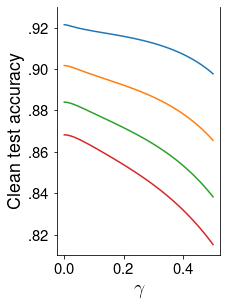

In [296]:
# gamma
plt.rc('font', size=15)
#plots = []
fig = plt.figure(figsize=(3.5,4.5))
ax = fig.add_subplot(111)
for i, noise in enumerate([0, 0.1, 0.2, 0.3]):
    f = lambdify(gamma, error_ctest.subs({sinv: 0.5 + noise, ssp: 0.1 + noise, xinv: 1, lamda: 0., xsp: np.sqrt(5)}), "numpy")
    res = [f(g) for g in np.linspace(0, ugamma, 100)]
    ax.plot(np.linspace(0, ugamma, 100), res, label="$\sigma^2_{noise}=" + str(noise) + "$")
    #plots.append(sympy.plotting.plot(error_ctest.subs({sinv: 0.5 + noise, ssp: 0.1 + noise, xinv: 1, lamda: 0., xsp: np.sqrt(5)}), linewidth=100,
    #                        xlim=(0, 0.3), ylim=(0.85, 1.0), ylabel="Clean test accuracy", xlabel="$\gamma$", show=False, label="$\sigma_{inv}=0.1$", legend=False))
    #if i > 0:
    #    plots[0].append(plots[i][0])

#move_sympyplot_to_axes(plots[0], ax)
ax.set_ylim(.81, .93)
ax.set_ylabel("Clean test accuracy", fontsize= 18)
ax.set_xlabel("$\gamma$", fontsize=20)
ax.yaxis.set_label_coords(-0.2, 0.5)
ax.xaxis.set_label_coords(0.5, -0.1)
ax.spines['top'].set_visible(False)
#plt.legend(fontsize=14)
plt.tight_layout()

ticks = ax.yaxis.get_ticklabels()
for ent in ticks:
    temp = ent.get_text().replace("0.", ".")
    ent.set_text(temp)
ax.yaxis.set_ticklabels(ticks)
plt.savefig("figs/fig6/error_ctest_noise.png", dpi=300)

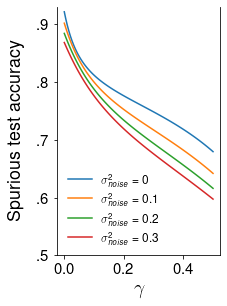

In [299]:
plt.rc('font', size=15)
fig = plt.figure(figsize=(3.5,4.5))
ax = fig.add_subplot(111)
#plots = []
for i, noise in enumerate([0, 0.1, 0.2, 0.3]):
    f = lambdify(gamma, error_stest.subs({sinv: 0.5 + noise, ssp: 0.1 + noise, xinv: 1, lamda: 0., xsp: np.sqrt(5)}), "numpy")
    res = [f(g) for g in np.linspace(0, ugamma, 100)]
    ax.plot(np.linspace(0, ugamma, 100), res, label="$\sigma^2_{noise}=" + str(noise) + "$")
    #plots.append(sympy.plotting.plot(error_stest.subs({sinv: 0.5 + noise, ssp: 0.1 + noise, xinv: 1, lamda: 0., xsp: np.sqrt(5)}), linewidth=100,
    #                        xlim=(0, 0.2), ylim=(0.65, 0.95), ylabel="Spurious test accuracy", xlabel="$\gamma$", show=False, label="$\sigma_{inv}=0.1$", legend=False))
    #if i > 0:
    #    plots[0].append(plots[i][0])

#move_sympyplot_to_axes(plots[0], ax)
ax.set_ylim(.5, .93)
ax.set_xlabel("$\gamma$", fontsize= 20)
ax.set_ylabel("Spurious test accuracy", fontsize= 18)
ax.yaxis.set_label_coords(-0.2, 0.5)
ax.xaxis.set_label_coords(0.5, -0.1)
ax.spines['top'].set_visible(False)
plt.legend(fontsize=12, frameon=False)
plt.tight_layout()

ticks = ax.yaxis.get_ticklabels()
for ent in ticks:
    temp = ent.get_text().replace("0.", ".")
    ent.set_text(temp)
ax.yaxis.set_ticklabels(ticks)

plt.savefig("figs/fig6/error_stest_noise.png", dpi=300)

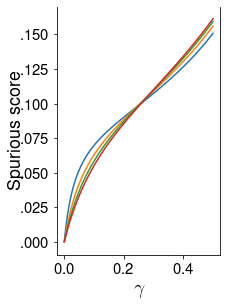

In [304]:
plt.rc('font', size=15)
fig = plt.figure(figsize=(3.5,4.5))
ax = fig.add_subplot(111)
#plots = []
for i, noise in enumerate([0, 0.1, 0.2, 0.3]):
    f = lambdify(gamma, sscore.subs({sinv: 0.5 + noise, ssp: 0.1 + noise, xinv: 1, lamda: 0., xsp: np.sqrt(5)}), "numpy")
    res = [f(g) for g in np.linspace(0, ugamma, 100)]
    ax.plot(np.linspace(0, ugamma, 100), res)
    #plots.append(sympy.plotting.plot(sscore.subs({sinv: 0.5 + noise, ssp: 0.1 + noise, xinv: 1, lamda: 0., xsp: np.sqrt(5)}), linewidth=100,
    #                        xlim=(0, 0.2), ylim=(0.0, 0.14), ylabel="Spurious score", xlabel="$\gamma$", show=False, label="$\sigma_{inv}=0.1$", legend=False))
    #if i > 0:
    #    plots[0].append(plots[i][0])
#move_sympyplot_to_axes(plots[0], ax)
ax.set_xlabel("$\gamma$", fontsize= 20)
ax.set_ylabel("Spurious score", fontsize= 18)

ax.set_ylim(-0.01, .17)
ax.yaxis.set_label_coords(-0.20, 0.5)
ax.xaxis.set_label_coords(0.5, -0.1)
ax.spines['top'].set_visible(False)
plt.tight_layout()

ticks = ax.yaxis.get_ticklabels()
for ent in ticks:
    temp = ent.get_text().replace("0.", ".")
    ent.set_text(temp)
_ = ax.yaxis.set_ticklabels(ticks)
plt.savefig
plt.savefig("figs/fig6/sscore_noise.png", dpi=300)

### L2

In [275]:
lams = [0, 1.0, 10.0, 100.0]

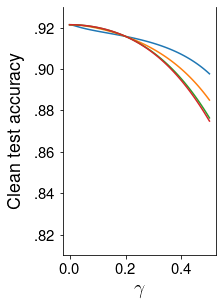

In [297]:
# gamma
plt.rc('font', size=15)
fig = plt.figure(figsize=(3.5,4.5))
ax = fig.add_subplot(111)
#plots = []
for i, lam in enumerate(lams):
    f = lambdify(gamma, error_ctest.subs({sinv: 0.5, ssp: 0.1, xinv: 1, lamda: lam, xsp: np.sqrt(5)}), "numpy")
    res = [f(g) for g in np.linspace(0, ugamma, 100)]
    ax.plot(np.linspace(0, ugamma, 100), res, label=f"$\lambda={lam}$")
    #plots.append(sympy.plotting.plot(error_ctest.subs({sinv: 0.5, ssp: 0.1, xinv: 1, lamda: lam, xsp: np.sqrt(5)}), linewidth=100,
    #                        xlim=(0, 0.3), ylim=(0.92, 0.93), ylabel="Clean test accuracy", xlabel="$\gamma$", show=False, label="$\sigma_{inv}=0.1$", legend=False))
    #if i > 0:
    #    plots[0].append(plots[i][0])
#move_sympyplot_to_axes(plots[0], ax)
ax.set_xlabel("$\gamma$", fontsize= 20)
ax.set_ylabel("Clean test accuracy", fontsize=18)

ax.set_ylim(.81, .93)
ax.yaxis.set_label_coords(-0.25, 0.5)
ax.xaxis.set_label_coords(0.5, -0.1)
ax.spines['top'].set_visible(False)
#plt.legend(fontsize=14)
plt.tight_layout()

ticks = ax.yaxis.get_ticklabels()
for ent in ticks:
    temp = ent.get_text().replace("0.", ".")
    ent.set_text(temp)
ax.yaxis.set_ticklabels(ticks)
plt.savefig("figs/fig6/error_ctest_l2.png", dpi=300)

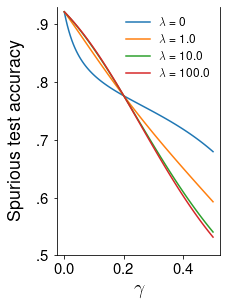

In [300]:
plt.rc('font', size=15)
fig = plt.figure(figsize=(3.5,4.5))
ax = fig.add_subplot(111)
#plots = []
for i, lam in enumerate(lams):
    f = lambdify(gamma, error_stest.subs({sinv: 0.5, ssp: 0.1, xinv: 1, lamda: lam, xsp: np.sqrt(5)}), "numpy")
    res = [f(g) for g in np.linspace(0, ugamma, 100)]
    ax.plot(np.linspace(0, ugamma, 100), res, label=f"$\lambda={lam}$")
    #plots.append(sympy.plotting.plot(error_stest.subs({sinv: 0.5, ssp: 0.1, xinv: 1, lamda: lam, xsp: np.sqrt(5)}), linewidth=100,
    #                        xlim=(0, 0.3), ylim=(0.7, 0.95), ylabel="Spurious test accuracy", xlabel="$\gamma$", show=False, label="$\sigma_{inv}=0.1$", legend=False))
    #if i > 0:
    #    plots[0].append(plots[i][0])
#move_sympyplot_to_axes(plots[0], ax)
ax.set_xlabel("$\gamma$", fontsize= 20)
ax.set_ylabel("Spurious test accuracy", fontsize=18)

ax.set_ylim(.5, .93)
ax.yaxis.set_label_coords(-0.2, 0.5)
ax.xaxis.set_label_coords(0.5, -0.1)
ax.spines['top'].set_visible(False)
plt.legend(fontsize=12, frameon=False)
plt.tight_layout()

ticks = ax.yaxis.get_ticklabels()
for ent in ticks:
    temp = ent.get_text().replace("0.", ".")
    ent.set_text(temp)
ax.yaxis.set_ticklabels(ticks)

plt.savefig("figs/fig6/error_stest_l2.png", dpi=300)

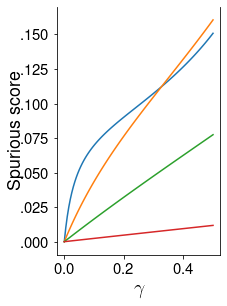

In [303]:
plt.rc('font', size=15)
fig = plt.figure(figsize=(3.5,4.5))
ax = fig.add_subplot(111)
#plots = []
for i, lam in enumerate(lams):
    f = lambdify(gamma, sscore.subs({sinv: 0.5, ssp: 0.1, xinv: 1, lamda: lam, xsp: np.sqrt(5)}), "numpy")
    res = [f(g) for g in np.linspace(0, ugamma, 100)]
    ax.plot(np.linspace(0, ugamma, 100), res)
    #plots.append(sympy.plotting.plot(sscore.subs({sinv: 0.5, ssp: 0.1, xinv: 1, lamda: lam, xsp: np.sqrt(5)}), linewidth=100,
    #                        xlim=(0, 0.3), ylim=(0.0, 0.12), ylabel="Spurious score", xlabel="$\gamma$", show=False, label="$\sigma_{inv}=0.1$", legend=False))
    #if i > 0:
    #    plots[0].append(plots[i][0])

#move_sympyplot_to_axes(plots[0], ax)
ax.set_ylabel("Spurious score", fontsize=18)
ax.set_xlabel("$\gamma$", fontsize= 20)
ax.set_ylim(-0.01, .17)
ax.yaxis.set_label_coords(-0.20, 0.5)
ax.xaxis.set_label_coords(0.5, -0.1)
ax.spines['top'].set_visible(False)
plt.tight_layout()

ticks = ax.yaxis.get_ticklabels()
for ent in ticks:
    temp = ent.get_text().replace("0.", ".")
    ent.set_text(temp)
_ = ax.yaxis.set_ticklabels(ticks)
plt.savefig
plt.savefig("figs/fig6/sscore_l2.png", dpi=300)

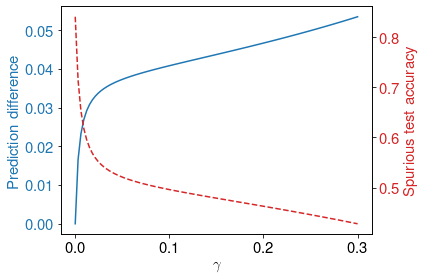

In [13]:
ugamma = 0.3
fontsize = 15

fig, ax1 = plt.subplots()
f = lambdify(gamma, sscore.subs({sinv: 1.0, ssp: 0.05, xinv: 1, lamda: 0., xsp: 5}), "numpy")
scores = [f(g) for g in np.linspace(0, ugamma, 100)]
ticks = np.linspace(0, ugamma, 100)

color = 'tab:blue'
ax1.plot(ticks, res, color=color)
ax1.set_xlabel("$\gamma$", fontsize=fontsize)
ax1.set_ylabel("Prediction difference", fontsize=fontsize, color=color)
ax1.tick_params(axis='y', labelcolor=color, labelsize=fontsize)
ax1.tick_params(axis='x', labelsize=fontsize)

f = lambdify(gamma, error_stest.subs({sinv: 1.0, ssp: 0.05, xinv: 1, lamda: 0., xsp: 5}), "numpy")
spaccs = [f(g) for g in np.linspace(0, ugamma, 100)]
color = 'tab:red'
ax2 = ax1.twinx()
ax2.set_ylabel('Spurious test accuracy', fontsize=fontsize, color=color)  # we already handled the x-label with ax1
ax2.plot(ticks, spaccs, color=color, linestyle='--')
ax2.tick_params(axis='y', labelcolor=color, labelsize=fontsize)

fig.tight_layout()
plt.savefig("figs/phase_transition.png", dpi=300)